In [1]:
#Importing the dataframe from Excel

import pandas as pd

df=pd.read_excel('C:/Users/vikra/.spyder-py3/CMC Database.xlsx', sheet_name = 'Sheet4', header=0)

print(df)

     Serial No.  Surfactant No.        Charge           Surfactant Name  \
0             1             1.0       Anionic  Sodium Dodecyl 1 Sulfate   
1             2             NaN       Anionic  Sodium Dodecyl 1 Sulfate   
2             3             2.0       Anionic    Sodium Octyl 1 Sulfate   
3             4             NaN       Anionic    Sodium Octyl 1 Sulfate   
4             5             3.0       Anionic    Sodium Decyl 1 Sulfate   
..          ...             ...           ...                       ...   
262         263           256.0  Zwitterionic  C12H25N+(CH3)2(CH2)5COO−   
263         264           257.0  Zwitterionic  C12H25N+(CH3)2(CH2)7COO−   
264         265           258.0  Zwitterionic     C8H17CH(COO-)N+(CH3)3   
265         266           259.0  Zwitterionic    C10H21CH(COO-)N+(CH3)3   
266         267           260.0  Zwitterionic    C12H25CH(COO-)N+(CH3)3   

    Formula                   Head Group  \
0       NaN                      Sulfate   
1       NaN

In [3]:
# Identify target column (output). For this example, wine quality is the target property
target = ['-log CMC']
# Identify features (inputs)
features = (list(set(list(df.columns))-set(target)))
# Print features
features

['Charge',
 'Temp (oC)',
 'Serial No.',
 'Formula',
 'CMC (M)',
 'Head Group',
 'Surfactant No.',
 '2^-log(CMC)',
 'SMILES Representation',
 'Surfactant Name']

In [4]:
headers = df.columns.tolist()
headers

['Serial No.',
 'Surfactant No.',
 'Charge',
 'Surfactant Name',
 'Formula',
 'Head Group',
 'SMILES Representation',
 'Temp (oC)',
 'CMC (M)',
 '-log CMC',
 '2^-log(CMC)']

In [5]:
#Creating dataset with only required data

df2 = df.drop(df.columns[[0,1,2,3,4,5,8,10]], axis= 1)
df2 = df2.drop([28,29,51])


#df2 = df2.loc[130:135, :]
df2 = df2.reset_index()
df2 = df2.drop(['index'], axis= 1)

df2

,SMILES Representation,Temp (oC),-log CMC
0,CCCCCCCCCCCCOS(=O)(=O)[O-].[Na+],20,2.072117
1,CCCCCCCCCCCCOS(=O)(=O)[O-].[Na+],25,2.080922
2,CCCCCCCCOS(=O)(=O)[O-].[Na+],20,0.873869
3,CCCCCCCCOS(=O)(=O)[O-].[Na+],25,0.885056
4,CCCCCCCCCCOS(=O)(=O)[O-].[Na+],20,1.474955
...,...,...,...
259,CCCCCCCCCCCC[N+](C)(C)CCCCCC(=O)[O-],25,2.585027
260,CCCCCCCCCCCC[N+](C)(C)CCCCCCCC(=O)[O-],25,2.823909
261,CCCCCCCCC(C(=O)[O-])[N+](C)(C)C,27,1.013228
262,CCCCCCCCCCC(C(=O)[O-])[N+](C)(C)C,27,1.886057


In [6]:
#Checks to see if there is any null values within each of the columns of the database.
df2.isnull().sum()

SMILES Representation    0
Temp (oC)                0
-log CMC                 0
dtype: int64

In [7]:
import numpy as np
import rdkit as rd
from rdkit import Chem, DataStructs, rdBase
#draw the molecules
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import AtomPairs
from rdkit.Chem.AtomPairs.Pairs import GetAtomPairFingerprintAsBitVect

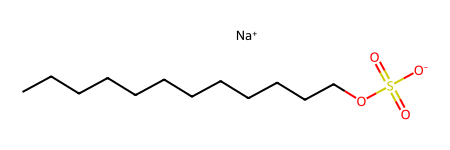

In [8]:
smile = df2.iloc[0,0]
mol = Chem.MolFromSmiles(smile)
mol

In [9]:
#Create a function that will convert the smiles into a morgan fingerprint
def MoleculeGen(rad: int, dataframe: pd.DataFrame) -> pd.DataFrame:
    #initilise empty lists for holding the mol drawings and morgan fingerprints
    mol_list = []
    fin_list = []
    i = 0
    
    for smile in dataframe['SMILES Representation']:
        i += 1
        try:
            #Generate the molecular drawing of the smile
            mol = Chem.MolFromSmiles(smile)
            mol_list.append(mol)
            #Generate the morgan fingerprint of the smile in question
            mf_bitvect = AllChem.GetMorganFingerprintAsBitVect(mol, radius= rad, nBits= 2**10)
            #initialise a temporary array that will have the bit vector mapped onto to convert from bit vector to numpy array\
            #(this is because we can only use np arrays and not bit vectors within python)
            temp = np.zeros((0,), dtype= np.int8)
            DataStructs.ConvertToNumpyArray(mf_bitvect, temp)
            fin_list.append(temp)
           
        except:
            print(i, smile)
    #convert the np array to a dataframe that we can then add to the main dataframe in question
    fin_list = pd.DataFrame(fin_list)
    #Add the fingerprint list to the main dataframe along the columns (axis = 1)
    dataframe = pd.concat([dataframe, fin_list], axis= 1)
    return dataframe

In [10]:
#Call the function to generate the fingerprints
df3 = MoleculeGen(7, df2)

#drop the smile columns since this will  not be passed to the machine learning model
df3 = df3.drop(['SMILES Representation'], axis = 1)
#denote the target heading
target = ['-log CMC']
#define all other headings as the input features for the model
features = (list(set(list(df3.columns))-set(target)))
#get the values of the input features and output features
x_data = df3[features].values
y_data = df3[target].values
x_data.shape

[19:58:00] DEPRECATION WARNING: please use MorganGenerator
[19:58:00] DEPRECATION WARNING: please use MorganGenerator
[19:58:00] DEPRECATION WARNING: please use MorganGenerator
[19:58:00] DEPRECATION WARNING: please use MorganGenerator
[19:58:00] DEPRECATION WARNING: please use MorganGenerator
[19:58:00] DEPRECATION WARNING: please use MorganGenerator
[19:58:00] DEPRECATION WARNING: please use MorganGenerator
[19:58:00] DEPRECATION WARNING: please use MorganGenerator
[19:58:00] DEPRECATION WARNING: please use MorganGenerator
[19:58:00] DEPRECATION WARNING: please use MorganGenerator
[19:58:00] DEPRECATION WARNING: please use MorganGenerator
[19:58:00] DEPRECATION WARNING: please use MorganGenerator
[19:58:00] DEPRECATION WARNING: please use MorganGenerator
[19:58:00] DEPRECATION WARNING: please use MorganGenerator
[19:58:00] DEPRECATION WARNING: please use MorganGenerator
[19:58:00] DEPRECATION WARNING: please use MorganGenerator
[19:58:00] DEPRECATION WARNING: please use MorganGenerat

(264, 1025)

In [11]:
# Import scikit learn classifier and regressor.
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

# Tool for splitting sets. Needed to split training and test data
from sklearn.model_selection import train_test_split

# Module to normalized data
from sklearn import preprocessing

# Tool for calculation of the mean square error (mse)
from sklearn.metrics import mean_squared_error

# Tool for calculating R2 score
from sklearn.metrics import r2_score

# Split data for training and testing. In this example, the splits is 80:20
x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size=0.2,random_state=5,shuffle=True)

print(x_train.shape)
print(x_test.shape)

(211, 1025)
(53, 1025)


In [12]:
#Using Standard Scaler to scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_data_scaled = scaler.fit_transform(x_data)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)
y_data_scaled = scaler.fit_transform(y_data)


y_train_scaled.shape

(211, 1)

In [13]:
#x_train[0] == x_train[1]

In [14]:

# Create an Artificial Neural Network architecture 
clf = MLPRegressor(hidden_layer_sizes=(4),solver='lbfgs',alpha=1e-5,random_state=5,max_iter=2000)

# Fit data to the ANN
clf.fit(x_train_scaled,y_train_scaled.ravel())
r2 = clf.score(x_train_scaled,y_train_scaled.ravel())

print('The R2 after fitting is: {0:6.5f}'.format(r2))

The R2 after fitting is: 0.95936


In [15]:
#MSE / RRMSE of Data
predict_train_set = clf.predict(x_train_scaled)
predict_test_set = clf.predict(x_test_scaled)
mse = mean_squared_error(y_data_scaled, clf.predict(x_data_scaled))

print(mse)

0.08754247259996657


In [16]:
#Test dataset MSE
mean_squared_error(y_test_scaled, predict_test_set)

0.32188274373867004

In [17]:

#Training dataset MSE
mean_squared_error(y_train_scaled, predict_train_set)

0.04063784302495499

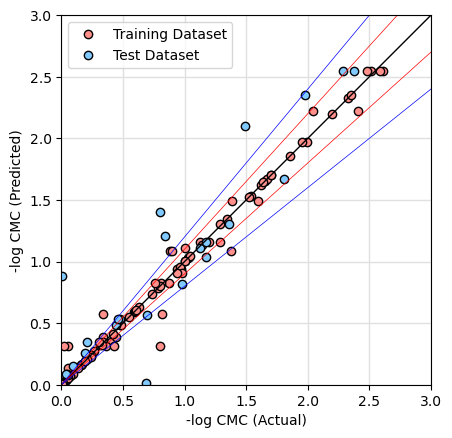

<Figure size 5940x5400 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#plt.figure(figsize=(12,8))
ax1=plt.subplot(1, 1, 1)

ax1.plot(y_train_scaled,predict_train_set,marker='o',ls='None',mec='k',mfc='#FF908C',label='Training Dataset')
ax1.plot(y_test_scaled,predict_test_set,marker='o',ls='None',mec='k',mfc='#80CAFF',label='Test Dataset')
ax1.legend()


graph_size = 3


ax1.plot([0,graph_size],[0,graph_size],'-k',lw=1)
ax1.plot([0,graph_size],[0,graph_size*0.9],'-r',lw=0.5)
ax1.plot([0,graph_size],[0,graph_size*1.1],'-r',lw=0.5)
ax1.plot([0,graph_size],[0,graph_size*0.8],'-b',lw=0.5)
ax1.plot([0,graph_size],[0,graph_size*1.2],'-b',lw=0.5)


ax1.set_xlim([0,graph_size])
ax1.set_ylim([0,graph_size])
ax1.set_xlabel('-log CMC (Actual)') #size=18, if you want to change font size
ax1.set_ylabel('-log CMC (Predicted)')


#ax1.grid()
plt.gca().set_aspect('equal', adjustable='box')

## Figure property 
figure(figsize=(3.3, 3), dpi=1800) # for figsize: width, height in inches
#ax1.autolayout : true # for labels not being cut out

## Axes
ax1.titlesize : 8
ax1.labelsize : 8


In [19]:
#Finding number of points for than 20% inaccurate

iterations = y_test_scaled.size

log_CMC_list = []

for i in range(0,iterations):
    q = predict_test_set[i]/y_test_scaled[i]
    if q > 1.2 or q < 0.8:
        log_CMC_list.append(y_test_scaled[i])
    i += 1

print(len(log_CMC_list)*100/iterations)
print('No. of predictions with accuracy lower than 80%:', len(log_CMC_list))
print('Size of test dataset:', iterations)

50.943396226415096
No. of predictions with accuracy lower than 80%: 27
Size of test dataset: 53
